In [22]:
#import 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys
import csv
import cv2
from os import path
from os import listdir
from os.path import isfile, join , isdir
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline

In [23]:
# open all csv files

file_path = "."

csv_lines = []

csvfiles = [f for f in listdir(file_path+ "\\Data\\") if isfile(join(file_path + "\\Data\\",f))]
for c in csvfiles:
        
    with open(file_path + "\\Data\\"+c) as f:
        content = csv.reader(f)
        for line in content:
            csv_lines.append(line)

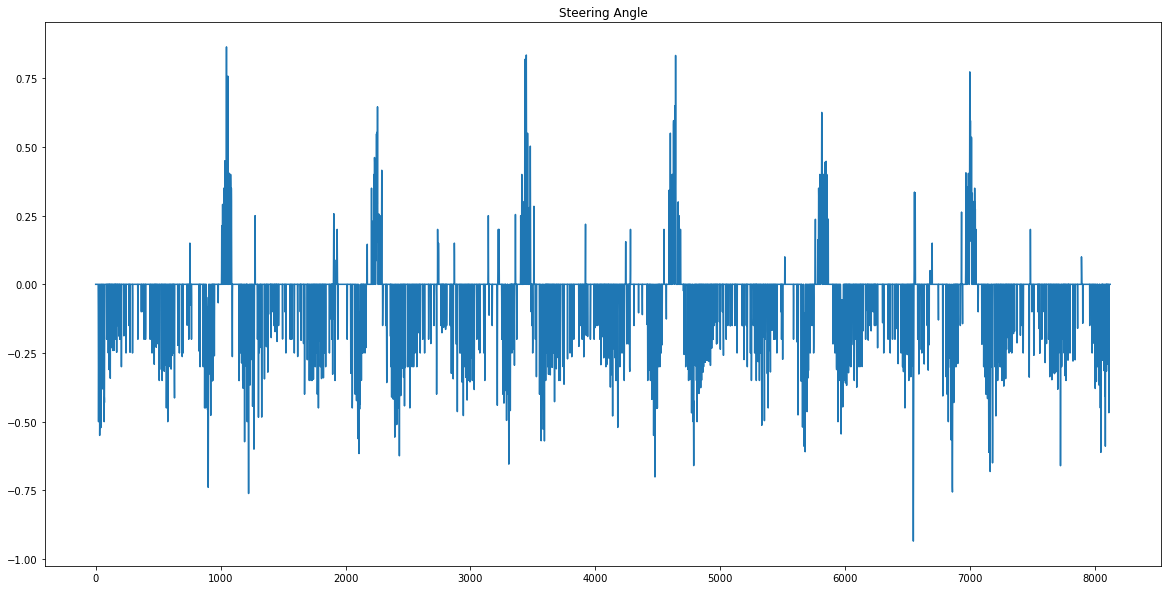

In [24]:
csv_lines = np.array(csv_lines)

plt.figure(figsize = (20,10))

plt.plot(csv_lines[:,3])
plt.title('Steering Angle')

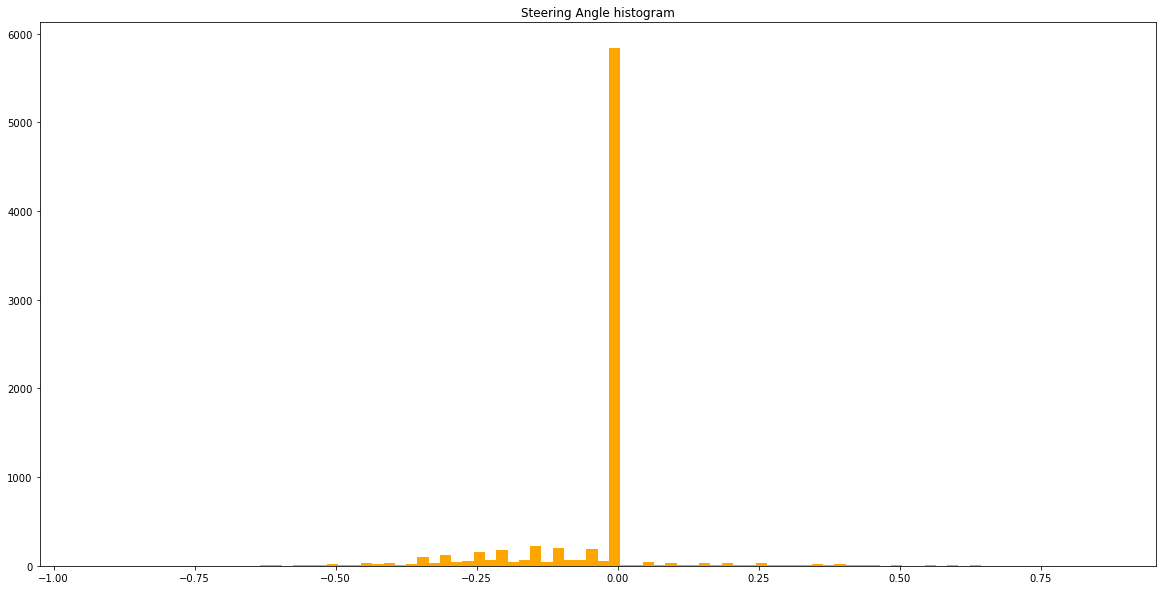

In [25]:
angles = csv_lines[:,3].astype(float)

plt.figure(figsize = (20,10))
plt.hist(angles, bins=90, color= 'orange', linewidth=0.1)
plt.title('Steering Angle histogram')

5792
8122
0.713124846097
2330
2316


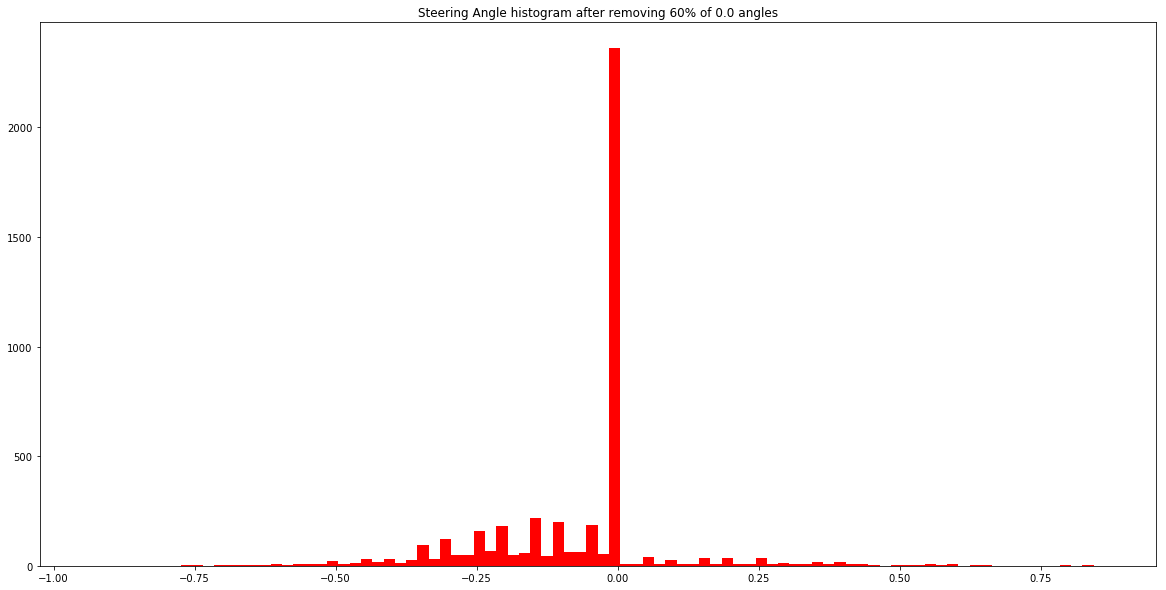

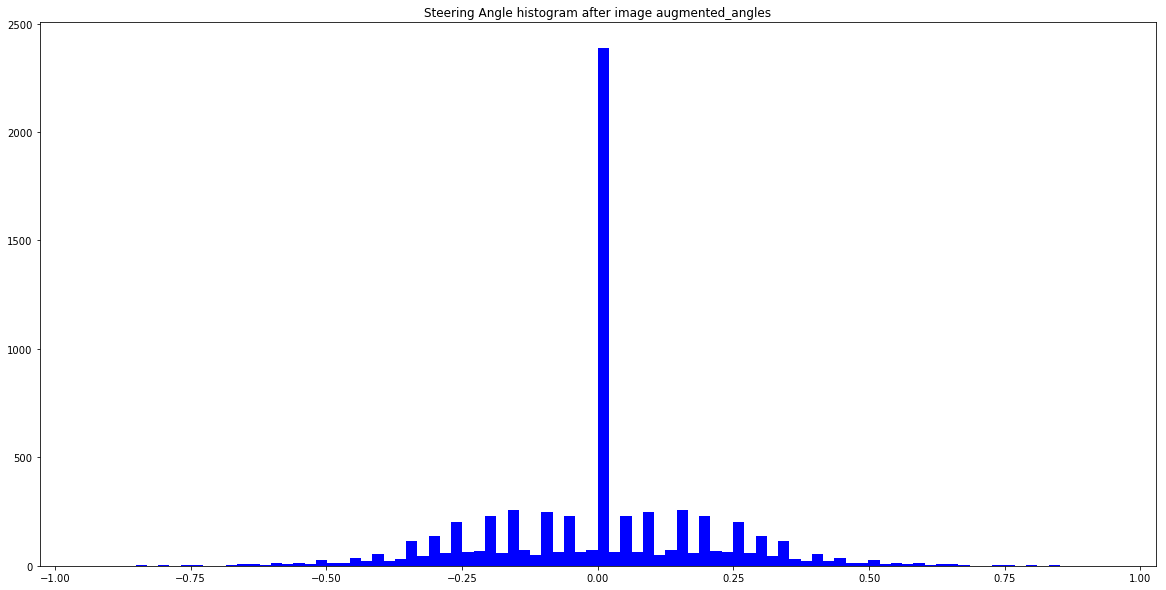

In [27]:
tol = 1e-16
zero_index = abs(angles) < tol

total_zeros = sum(zero_index)

print(total_zeros)
print(len(csv_lines))
print(total_zeros/len(csv_lines))

nonzero_angles_csv = csv_lines[~zero_index]
zero_angles_csv = csv_lines[zero_index]

keep_numbers = int((total_zeros*1) * 0.4)

keep_index = np.random.choice(len(zero_angles_csv), keep_numbers, replace=False)

zero_angles_csv = zero_angles_csv[keep_index]

print(len(nonzero_angles_csv))
print(len(zero_angles_csv))

new_csv = np.concatenate((nonzero_angles_csv, zero_angles_csv), axis=0)

new_csv = np.random.permutation(new_csv)


new_angles = new_csv[:,3].astype(float)

plt.figure(figsize = (20,10))
plt.hist(new_angles, bins=90, color= 'red', linewidth=0.1)
plt.title('Steering Angle histogram after removing 60% of 0.0 angles')

augmented_angles = []

for angle in new_angles:
    
    if abs(angle) >= tol:
        flipped_angle = -1.0 * angle
        augmented_angles.append(flipped_angle)
        

augmented_angles = np.array(augmented_angles)


new_angles = np.concatenate((augmented_angles, new_angles), axis=0)

plt.figure(figsize = (20,10))
plt.hist(new_angles, bins=90, color= 'blue', linewidth=0.1)
plt.title('Steering Angle histogram after image augmented_angles')

In [7]:
def pre_processing(data, file_path, keep = 0.4, eps = 1e-16, visual_data = False):
    data = np.array(data)
    angles = data[:,3].astype(float)
    zero_index = abs(angles) < eps
    
    total_zeros = sum(zero_index)
    nonzero_angles_csv = data[~zero_index]
    zero_angles_csv = data[zero_index]
    
    keep_numbers = int((total_zeros*1)*keep)
    
    keep_index = np.random.choice(len(zero_angles_csv), keep_numbers, replace=False)
    
    zero_angles_csv = zero_angles_csv[keep_index]
    new_csv = np.concatenate((nonzero_angles_csv, zero_angles_csv), axis=0)
    new_csv = np.random.permutation(new_csv)
    
    if visual_data:
        new_angles = new_csv[:,3].astype(float)
        plt.figure(figsize = (20,10))
        plt.hist(new_angles, bins=90, color= 'red', linewidth=0.1)
        
    data = list(new_csv)
    
    center_images = list(map(lambda x: file_path+x[0][2:], (i for i in data)))
    left_images = list(map(lambda x: file_path+x[1][2:], (i for i in data)))
    right_images = list(map(lambda x: file_path+x[2][2:], (i for i in data)))
    angles = list(map(float, (i[3] for i in data)))
    
    new_data = [[None for x in range(4)] for y in range(len(data))]


    for i in range(len(data)):
        
        new_data[i][0] = center_images[i]
        new_data[i][1] = left_images[i]
        new_data[i][2] = right_images[i]
        new_data[i][3] = angles[i]

    return new_data
    


In [8]:
def data_augmentation(images, angles, eps = 1e-16):
    augmented_images = []
    augmented_angles = []

    for image, angle in zip(images, angles):
        
        if not isinstance(angle, float):
            print("not float")
            angle = float(angle)
            
        augmented_images.append(image)
        augmented_angles.append(angle)

        flipped_image = cv2.flip(image,1)
        flipped_angle = -1.0 * angle
        augmented_images.append(flipped_image)
        augmented_angles.append(flipped_angle)
    return augmented_images, augmented_angles


In [9]:
def generator(samples, batch_size=32, train_flag = True):
    num_samples = len(samples)
    correction = 0.2

    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                center_path = batch_sample[0]

                center_image = cv2.imread(center_path)

                center_angle = float(batch_sample[3])
                

                images.append(center_image)
                angles.append(center_angle)

                if train_flag:
                    left_path = batch_sample[1]
                    right_path = batch_sample[2]
                    left_image = cv2.imread(left_path)
                    right_image = cv2.imread(right_path)
                    images.append(left_image)
                    angles.append(center_angle + correction)
                    images.append(right_image)
                    angles.append(center_angle - correction)

            images, angles = data_augmentation(images, angles)

            X_train = np.array(images)
            y_train = np.array(angles)


            yield shuffle(X_train, y_train)

In [18]:
def cnn_model():

    model = Sequential()
    model.add(Lambda(lambda x: (x/255) - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((70,25),(0,0))))

    model.add(Convolution2D(32,3,3,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Convolution2D(64,3,3,activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.3))
    model.add(Convolution2D(128,3,3, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Convolution2D(256,3,3, activation='relu'))
    model.add(MaxPooling2D())

    model.add(Flatten())
    model.add(Dense(128))
    model.add(Dense(64))
    model.add(Dense(1))

    return model

In [20]:
file_path = "."
num_epoch = 10

csv_lines = []

csvfiles = [f for f in listdir(file_path+ "\\Data\\") if isfile(join(file_path + "\\Data\\",f))]
for c in csvfiles:
    print(c)
    with open(file_path + "\\Data\\"+c) as f:
        content = csv.reader(f)
        for line in content:
            csv_lines.append(line)

            
csv_test_line = []

with open(file_path + "\\Data_test\\driving_log.csv") as f:
    content = csv.reader(f)
    for line in content:
        csv_test_line.append(line)


train_data = pre_processing(csv_lines, file_path)

valid_data = pre_processing(csv_test_line, file_path, 1.0)



train_generator = generator(train_data, batch_size=32)
validation_generator = generator(valid_data, batch_size=32, train_flag=False)

model = cnn_model()

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch= len(train_data)*6 , validation_data=validation_generator, nb_val_samples=len(valid_data), nb_epoch= num_epoch)

model.save('model.h5')

print("finish training")

driving_log.csv
Epoch 1/10
27876/27876 [==============================] - 62s - loss: 0.1335 - val_loss: 0.0146

In [21]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 160, 320, 3)   0           lambda_input_5[0][0]             
____________________________________________________________________________________________________
cropping2d_5 (Cropping2D)        (None, 65, 320, 3)    0           lambda_5[0][0]                   
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 63, 318, 32)   896         cropping2d_5[0][0]               
____________________________________________________________________________________________________
maxpooling2d_17 (MaxPooling2D)   (None, 31, 159, 32)   0           convolution2d_17[0][0]           
___________________________________________________________________________________________